In [0]:
from keras.applications import VGG16
from keras import backend as K

Using TensorFlow backend.


In [0]:
model = VGG16(weights='imagenet',
             include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
grads = K.gradients(loss, model.input)[0]

In [0]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128
step = 1

for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  
  x += 0.5
  x = np.clip(x, 0, 1)
  
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  
  return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  
  grads = K.gradients(loss, model.input)[0]
  
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  
  iterate = K.function([model.input], [loss, grads])
  
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
  
  step = 1
  
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    
  img = input_img_data[0]
  
  return deprocess_image(img)

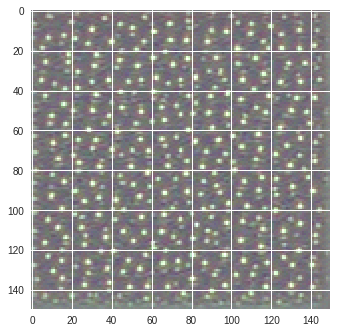

In [0]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

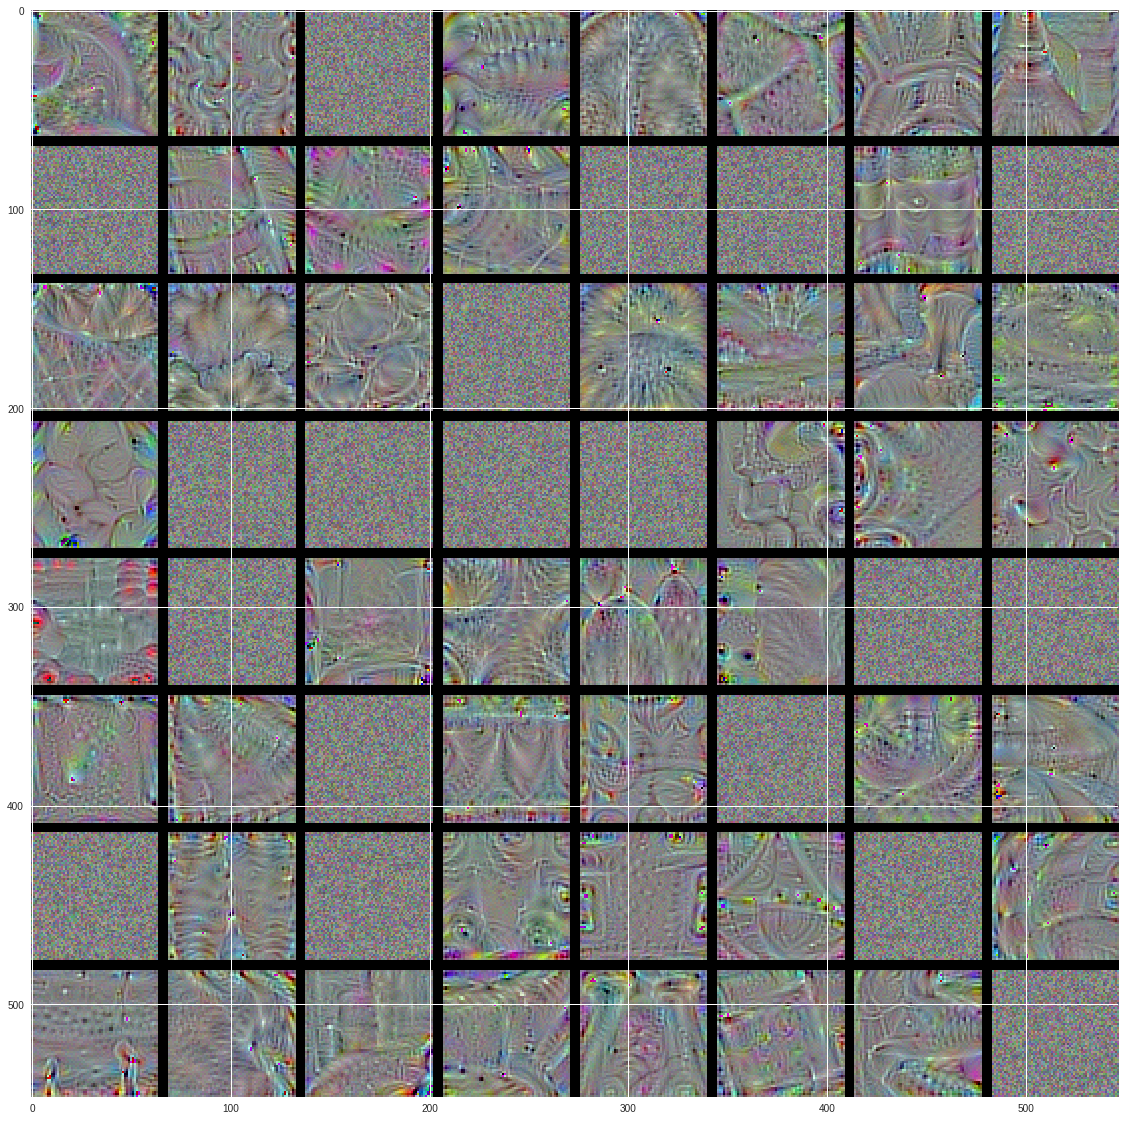

In [0]:
layer_name = 'block5_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j*8), size=size)
    
    horizontal_start = i*size + i*margin
    horizontal_end = horizontal_start + size
    vertical_start = j*size + j*margin
    vertical_end = vertical_start + size
    
    results[horizontal_start: horizontal_end,
           vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()

# Class Activation Map (CAM) visualization

In [0]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/a/a9/African_Bush_Elephants.jpg

--2018-11-27 19:04:12--  https://upload.wikimedia.org/wikipedia/commons/a/a9/African_Bush_Elephants.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6128818 (5.8M) [image/jpeg]
Saving to: ‘African_Bush_Elephants.jpg’

African_Bush_Elepha 100%[===================>]   5.84M  19.0MB/s    in 0.3s    

2018-11-27 19:04:12 (19.0 MB/s) - ‘African_Bush_Elephants.jpg’ saved [6128818/6128818]



In [0]:
!ls

African_Bush_Elephants.jpg  sample_data


In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np


img_path = 'African_Bush_Elephants.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
preds = model.predict(x)
decode_predictions(preds, top=3)[0]

[('n02504013', 'Indian_elephant', 0.42472124),
 ('n02504458', 'African_elephant', 0.3589989),
 ('n01871265', 'tusker', 0.15682185)]

In [0]:
np.argmax(preds[0])

385

In [0]:
output = model.output[:, 385]

last_conv_layer = model.get_layer('block5_conv3')

In [0]:
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis=-1)

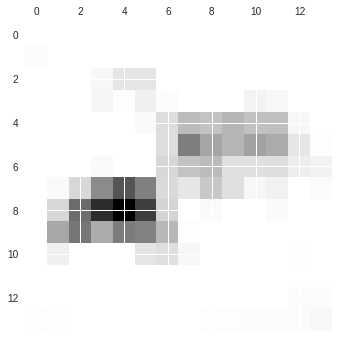

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [0]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap*0.4 + img

cv2.imwrite('detect.jpg', superimposed_img)

True

In [0]:
!ls

African_Bush_Elephants.jpg  detect.jpg	sample_data


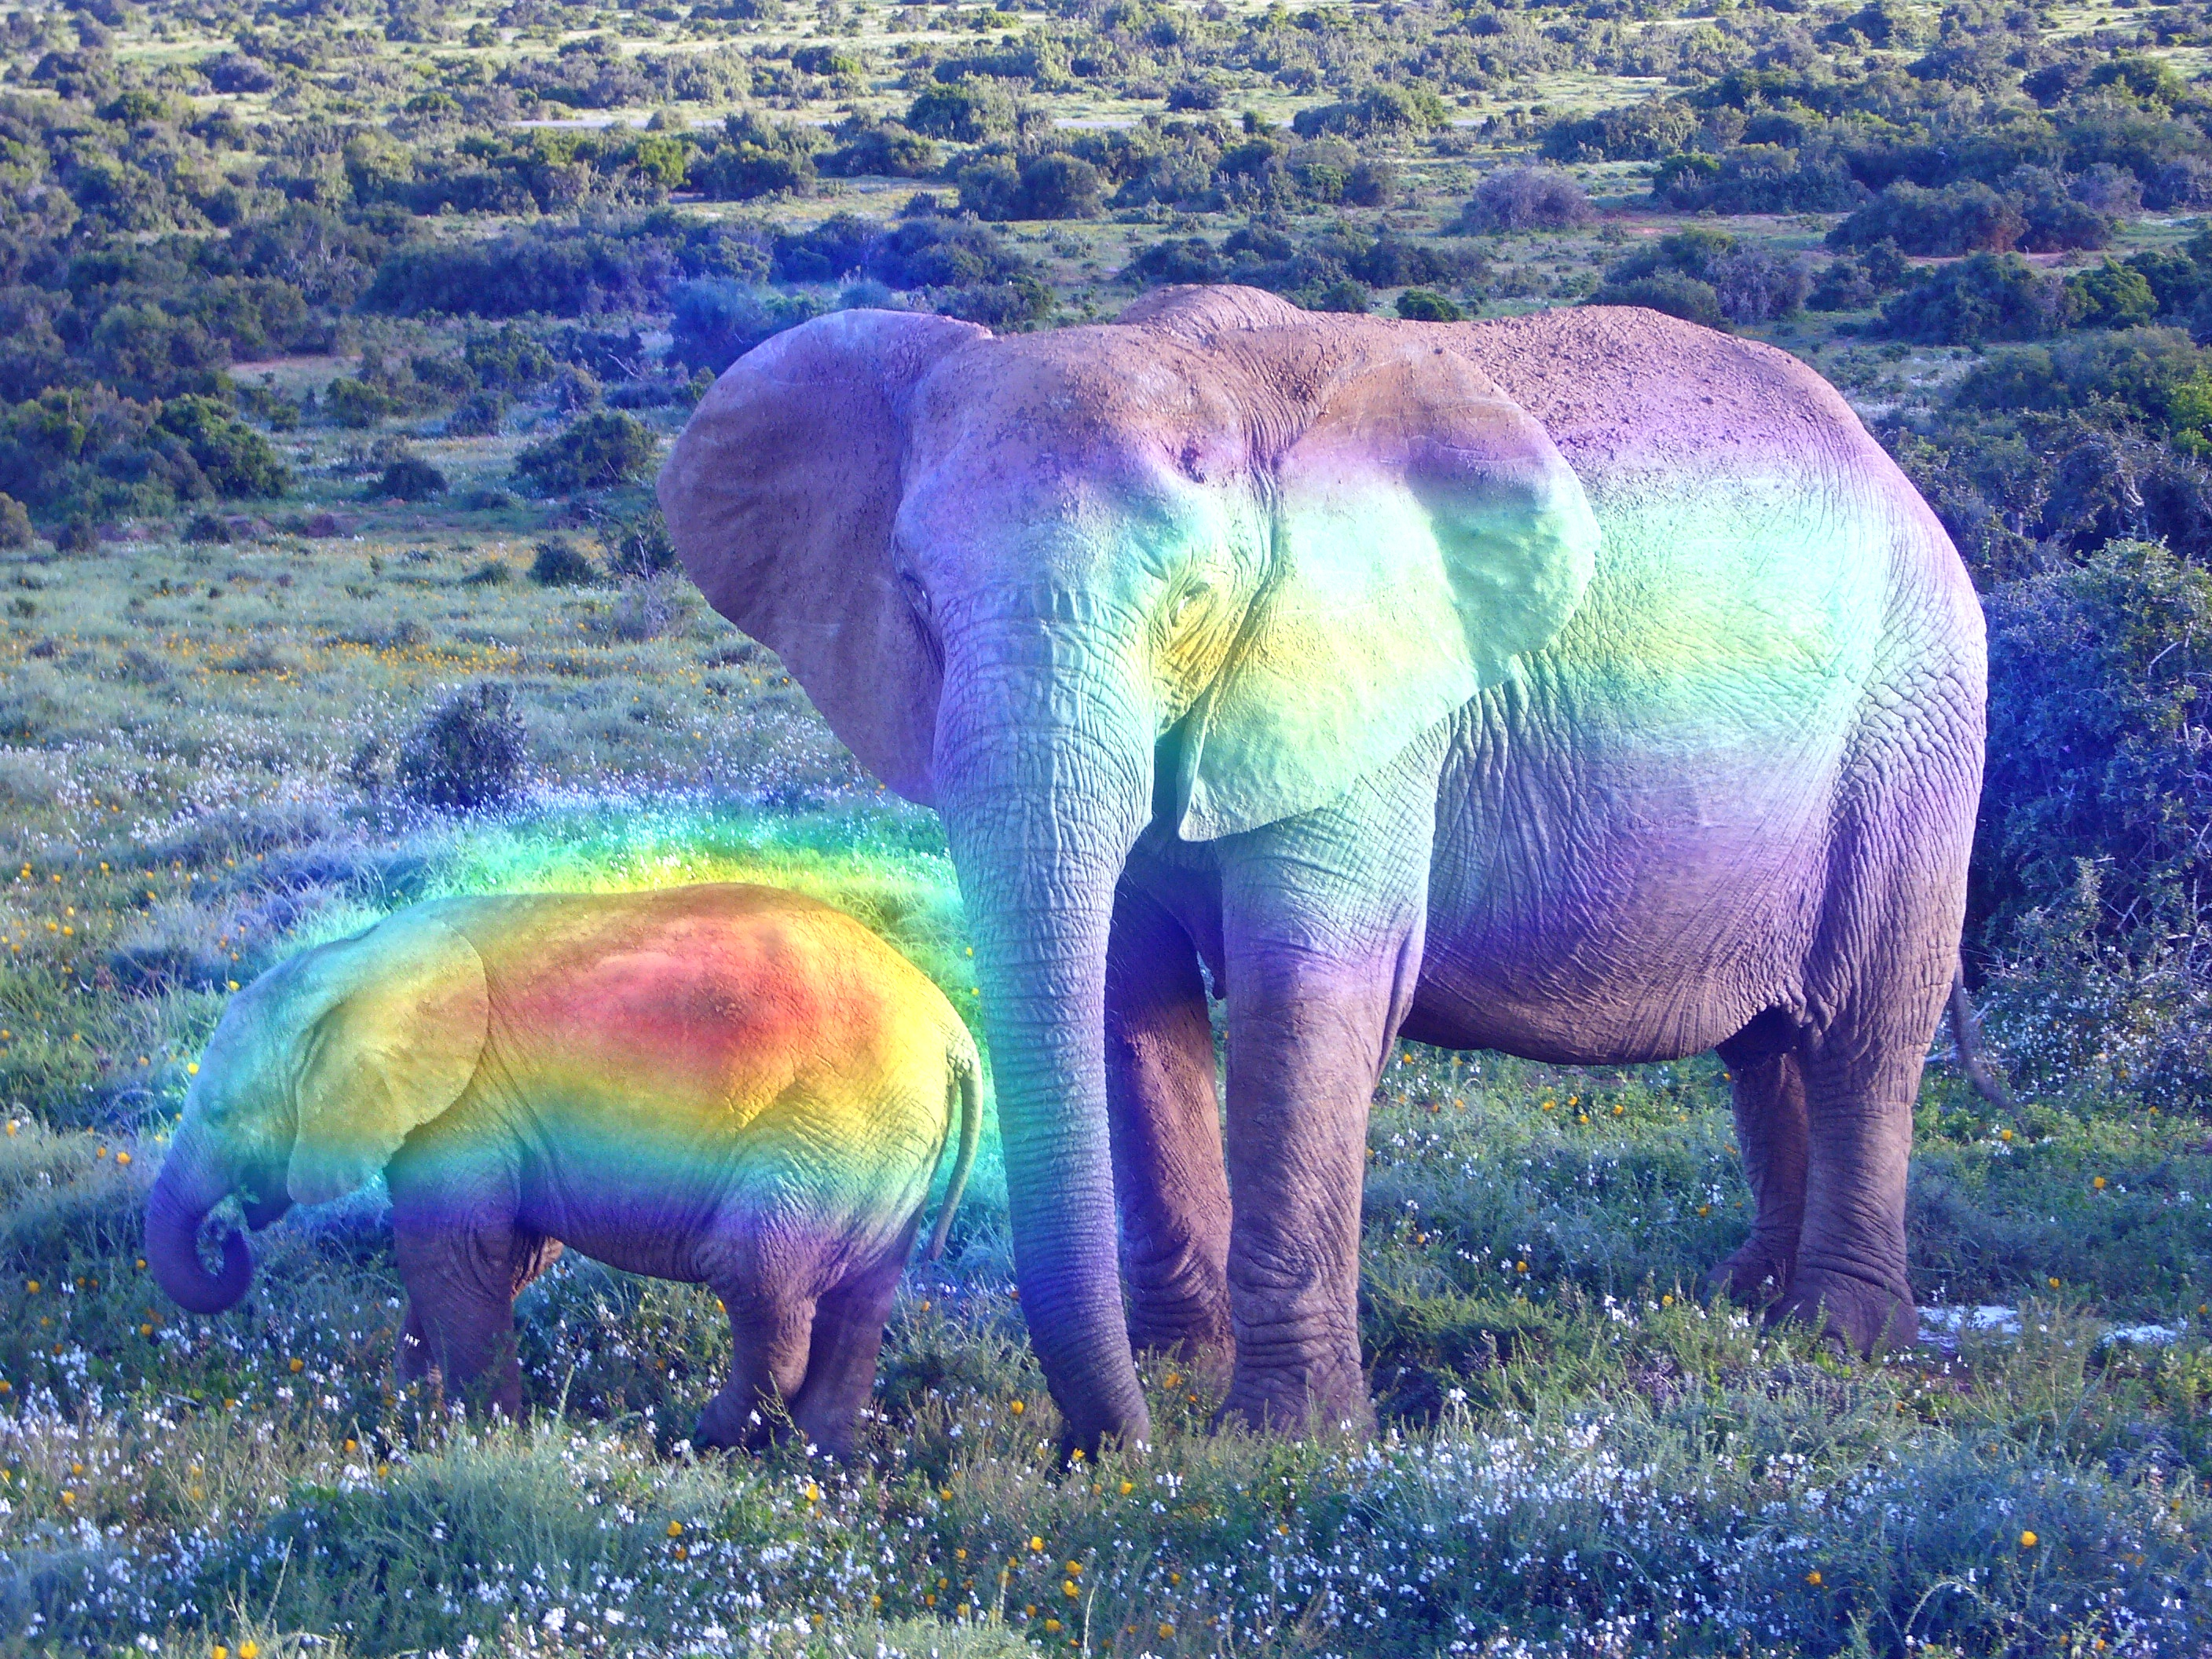

In [0]:
from IPython.display import Image
Image(filename='detect.jpg', width=300, height=300)